# Process the data into a useable format

In [1]:
import os
import quopri
import emoji
import re
import email
from bs4 import BeautifulSoup, NavigableString
import pandas as pd

def replace_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))

def replace_urls_based_on_context(html_content):
    soup = BeautifulSoup(html_content, 'lxml')
    for a_tag in soup.find_all('a'):
        href = a_tag.get('href', '')
        url_type = 'UNSAFE_' if href.startswith('http://') else ''
        if a_tag.img:
            a_tag.string = f'{url_type}IMAGE_URL'
        elif isinstance(a_tag.next, NavigableString) and a_tag.next.strip():
            a_tag.string = f'{url_type}LINK_URL'
        else:
            a_tag.string = f'{url_type}BUTTON_URL'
    return str(soup)

def replace_urls_in_text(text):
    # Replace http URLs
    http_url_pattern = re.compile(r'http://\S+')
    text = http_url_pattern.sub('UNSAFE_LINK_URL', text)
    
    # Replace https URLs
    https_url_pattern = re.compile(r'https://\S+')
    text = https_url_pattern.sub('LINK_URL', text)

    return text

def decode_quoted_printable(text):
    return quopri.decodestring(text.encode()).decode('utf-8', errors='replace')

def clean_text(html_content):
    # Create a BeautifulSoup object
    soup = BeautifulSoup(html_content, 'lxml')
    
    # Remove style tags and their content
    for style_tag in soup.find_all('style'):
        style_tag.decompose()
    
    # Now proceed with extracting text and further cleaning
    text = soup.get_text(separator=' ', strip=True)
    text = replace_emojis(text)
    
    # Decode any quoted-printable text
    text = quopri.decodestring(text.encode()).decode('utf-8', errors='replace')
    
    # Remove any remaining HTML encoded characters
    text = re.sub(r'&[a-zA-Z0-9#]+;', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip string of leading/trailing whitespace
    return text.strip()


def calculate_max_nesting_depth(soup):
    def get_depth(element, current_depth):
        children = element.find_all(recursive=False)
        if not children:
            return current_depth
        return max(get_depth(child, current_depth + 1) for child in children)
    return get_depth(soup, 0)

def preprocess_email(filepath):
    try:
        with open(filepath, 'rb') as file:
            raw_email = file.read()
        msg = email.message_from_bytes(raw_email)

        cleaned_text_parts = []
        soup = None

        if msg.is_multipart():
            for part in msg.walk():
                payload = part.get_payload(decode=True)
                if payload:  # Check if payload is not None
                    decoded_payload = quopri.decodestring(payload).decode('utf-8', errors='replace')
                    content_type = part.get_content_type()
                    if content_type == "text/html":
                        # First replace URLs
                        decoded_payload = replace_urls_based_on_context(decoded_payload)
                        # Then create soup object and clean the text
                        soup = BeautifulSoup(decoded_payload, 'lxml')
                        text = clean_text(str(soup))  # Pass the string representation of soup to clean_text
                        text = replace_emojis(text)
                        cleaned_text_parts.append(text)
                    elif content_type == "text/plain":
                        text = replace_urls_in_text(decoded_payload)
                        text = replace_emojis(text)
                        text = clean_text(text)
                        cleaned_text_parts.append(text)
        else:
            payload = msg.get_payload(decode=True)
            if payload:  # Check if payload is not None
                decoded_payload = quopri.decodestring(payload).decode('utf-8', errors='replace')
                if 'text/html' in msg.get_content_type():
                    # First replace URLs
                    decoded_payload = replace_urls_based_on_context(decoded_payload)
                    # Then create soup object and clean the text
                    soup = BeautifulSoup(decoded_payload, 'lxml')
                    text = clean_text(str(soup))  # Pass the string representation of soup to clean_text
                    text = replace_emojis(text)
                else:
                    text = replace_urls_in_text(decoded_payload)
                    text = replace_emojis(text)
                    text = clean_text(text)
                cleaned_text_parts.append(text)

        combined_text = ' '.join(cleaned_text_parts).strip()
        tag_count, tag_types, tag_to_text_ratio, max_nesting_depth = 0, {}, 0, 0
        if soup:
            tags = soup.find_all()
            tag_count = len(tags)
            tag_types = {tag.name: 0 for tag in tags}
            for tag in tags:
                tag_types[tag.name] += 1
            tag_to_text_ratio = tag_count / (len(combined_text.split()) + 1)
            max_nesting_depth = calculate_max_nesting_depth(soup)

        return {
            'text': combined_text,
            'tag_count': tag_count,
            'tag_types': tag_types,
            'tag_to_text_ratio': tag_to_text_ratio,
            'max_nesting_depth': max_nesting_depth
        }
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return {
            'text': '',
            'tag_count': 0,
            'tag_types': {},
            'tag_to_text_ratio': 0,
            'max_nesting_depth': 0
        }

## Now we need to prepare the data

We need mold the data into a format suitable for training a BERT transformer. We will create a dataframe datastructure do do this.

In [20]:
import os
import pandas as pd

# Directory containing the email files
# directory = 'C:\\Users\\ericb\\Desktop\\Research\\Primary@gmail.com\\Cleaned_Mail\\2023\\'
directory = 'C:\\Users\\ericb\\Desktop\\Research\\Bruce\\2017\\2017\\'
output_directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\data\\unwarranted_data\\'
# Iterate over each subdirectory in the directory
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        email_data_list = []

        # Iterate over each file in the subdirectory
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                preprocessed_email = preprocess_email(file_path)

                # Prepare row data as a dictionary
                row_data = {
                    'filename': filename,
                    'cleaned_text': preprocessed_email['text'],
                    'tag_count': preprocessed_email['tag_count'],
                    'tag_to_text_ratio': preprocessed_email['tag_to_text_ratio'],
                    'max_nesting_depth': preprocessed_email['max_nesting_depth']
                }
                # Update row data with tag types
                row_data.update(preprocessed_email['tag_types'])

                # Append the row data dictionary to the list
                email_data_list.append(row_data)
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

        # Convert the list of dictionaries to a DataFrame
        email_data = pd.DataFrame(email_data_list)

        # Fill NaN values with 0 for tag counts
        email_data.fillna(0, inplace=True)

        # Save the DataFrame to a CSV file named after the folder 
        csv_file_name = f'processed_emails_2017_{folder}.csv'

        email_data.to_csv(os.path.join(output_directory, csv_file_name), index=False)

        print(f"Data processing for {folder} complete. Saved to '{csv_file_name}'")
        # print number of rows and columns
        print(email_data.shape)


KeyboardInterrupt: 

## Sanity check

In [17]:
# open the csv file and read it into a pandas dataframe
df = pd.read_csv('processed_emails_08.csv')
df.head()


Index(['filename', 'cleaned_text', 'tag_count', 'tag_to_text_ratio',
       'max_nesting_depth', 'html', 'head', 'meta', 'title', 'style', 'body',
       'div', 'table', 'tr', 'td', 'a', 'img', 'span', 'br', 'p', 'link', 'b',
       'u', 'font', 'center', 'nobr', 'tbody', 'strong', 'em',
       'grammarly-desktop-integration', 'th', 'form', 'input', 'label',
       'section', 'i', 'h1', 'hr', 'h2', 'h3', 'h4', 'small',
       'forwardtoafriend', 'ul', 'li', 'thead', 's', 'script', 'header',
       'footer', 'block', 'sub', 'address', 'multiline', 'ol', 'sup',
       'picture', 'source', 'g', 'h5', 'blockquote', 'article', 'big',
       'colgroup', 'col', 'h6', 'map', 'area', 'mark', 'svg', 'rect', 'button',
       'time', 'tfoot', 'wbr'],
      dtype='object')


## Curious about word counts to help determine which transformer to use

In [14]:
import pandas as pd
import os
import numpy as np

# Directory containing the email files
directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project'

print("Starting data processing...")

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        try:
            df = pd.read_csv(os.path.join(directory, filename))
            print(f"Data loaded for {filename}.")
            print(f"Shape of DataFrame: {df.shape}")

            # Check if 'cleaned_text' column exists
            if 'cleaned_text' in df.columns:
                # Calculate word counts
                word_counts = df['cleaned_text'].dropna().apply(lambda x: len(x.split()))

                # Calculate max, average, median, and mode of word counts
                max_word_count = word_counts.max()
                avg_word_count = word_counts.mean()
                median_word_count = word_counts.median()
                mode_word_count = word_counts.mode()[0]

                print(f"File: {filename}")
                print(f"Maximum Word Count: {max_word_count}")
                print(f"Average Word Count: {avg_word_count:.2f}")
                print(f"Median Word Count: {median_word_count}")
                print(f"Mode Word Count: {mode_word_count}")
            else:
                print(f"File: {filename} does not contain a 'cleaned_text' column.")
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
        
        print("-" * 30)

print("Data processing complete.")


Starting data processing...
Processing file: processed_emails_05.csv
Data loaded for processed_emails_05.csv.
Shape of DataFrame: (7160, 65)
File: processed_emails_05.csv
Maximum Word Count: 32272
Average Word Count: 2871.83
Median Word Count: 2580.0
Mode Word Count: 88
------------------------------
Processing file: processed_emails_06.csv
Data loaded for processed_emails_06.csv.
Shape of DataFrame: (19266, 72)
File: processed_emails_06.csv
Maximum Word Count: 37784
Average Word Count: 2684.72
Median Word Count: 2418.0
Mode Word Count: 268
------------------------------
Processing file: processed_emails_07.csv
Data loaded for processed_emails_07.csv.
Shape of DataFrame: (26704, 74)
File: processed_emails_07.csv
Maximum Word Count: 60325
Average Word Count: 2258.48
Median Word Count: 1749.0
Mode Word Count: 1138
------------------------------
Processing file: processed_emails_08.csv
Data loaded for processed_emails_08.csv.
Shape of DataFrame: (34262, 75)
File: processed_emails_08.csv
M

# Just a script to check the features extracted

In [6]:
import pandas as pd

# Path to the CSV file
file_path = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\processed_emails_08.csv'

# Load the CSV file
df = pd.read_csv(file_path)

# Extract columns that represent HTML tags
tag_columns = [col for col in df.columns if col not in ['filename', 'cleaned_text', 'tag_count', 'tag_to_text_ratio', 'max_nesting_depth']]

# Create a dictionary to count the frequency of each tag
tag_frequency = {tag: df[tag].sum() for tag in tag_columns}

# Sort the dictionary by frequency
sorted_tag_frequency = dict(sorted(tag_frequency.items(), key=lambda item: item[1], reverse=True))

# Print the most common tags and their frequencies
print("Most Common HTML Tags:")
for tag, frequency in sorted_tag_frequency.items():
    print(f"{tag}: {frequency}")

# Check if there are tags with very low frequency
low_frequency_tags = {tag: freq for tag, freq in sorted_tag_frequency.items() if freq < 10}
print("\nHTML Tags with Low Frequency (less than 10 occurrences):")
for tag, frequency in low_frequency_tags.items():
    print(f"{tag}: {frequency}")



Most Common HTML Tags:
td: 2557986.0
tr: 2242309.0
table: 1558238.0
a: 1366885.0
img: 752756.0
div: 720490.0
span: 700363.0
tbody: 644209.0
p: 592273.0
br: 349204.0
strong: 202787.0
li: 153936.0
https:: 130679.0
meta: 112842.0
th: 100520.0
style: 89478.0
font: 51991.0
t: 47015.0
em: 44203.0
b: 41395.0
h2: 35868.0
title: 34970.0
html: 34262
body: 34252.0
h3: 28938.0
link: 25935.0
h1: 20796.0
redacted: 20565.0
i: 20394.0
col: 15916.0
center: 14124.0
head: 13353.0
ul: 13087.0
ol: 11463.0
u: 10578.0
h4: 9812.0
hr: 9624.0
tabl: 9594.0
tab: 8098.0
ta: 7857.0
im: 7443.0
pre: 7355.0
mailto:redacted: 6885.0
s: 6837.0
tbod: 5746.0
spa: 5544.0
http:: 5498.0
d: 5465.0
sp: 5112.0
tbo: 4454.0
tb: 3973.0
di: 3860.0
met: 3427.0
m: 3355.0
figure: 2964.0
https: 2856.0
h: 2546.0
figcaption: 1891.0
st: 1843.0
stro: 1820.0
ht: 1744.0
htt: 1681.0
sup: 1663.0
stron: 1645.0
http: 1548.0
wbr: 1543.0
str: 1509.0
h5: 1411.0
small: 1317.0
colgroup: 1288.0
mail: 1270.0
grammarly-desktop-integration: 1183.0
ag9uzxl

# Visualize the data word lengths

Starting data processing...
Processing file: processed_emails_2018_01.csv
Data loaded for processed_emails_2018_01.csv.
Shape of DataFrame: (19659, 70)
Word counts processed for processed_emails_2018_01.csv.
------------------------------
Processing file: processed_emails_2018_02.csv
Data loaded for processed_emails_2018_02.csv.
Shape of DataFrame: (11422, 69)
Word counts processed for processed_emails_2018_02.csv.
------------------------------
Processing file: processed_emails_2018_03.csv
Data loaded for processed_emails_2018_03.csv.
Shape of DataFrame: (25820, 70)
Word counts processed for processed_emails_2018_03.csv.
------------------------------
Processing file: processed_emails_2018_04.csv
Data loaded for processed_emails_2018_04.csv.
Shape of DataFrame: (8226, 64)
Word counts processed for processed_emails_2018_04.csv.
------------------------------
Processing file: processed_emails_2018_05.csv
Data loaded for processed_emails_2018_05.csv.
Shape of DataFrame: (1142, 58)
Word c

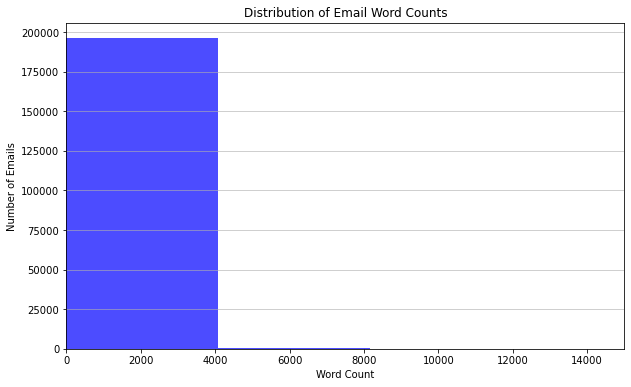

Data processing and histogram generation complete.


In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Directory containing the email files
directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project'

print("Starting data processing...")

# Initialize a list to collect all word counts
all_word_counts = []

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        try:
            df = pd.read_csv(os.path.join(directory, filename))
            print(f"Data loaded for {filename}.")
            print(f"Shape of DataFrame: {df.shape}")

            # Check if 'cleaned_text' column exists
            if 'cleaned_text' in df.columns:
                word_counts = df['cleaned_text'].dropna().apply(lambda x: len(x.split()))
                all_word_counts.extend(word_counts)
                print(f"Word counts processed for {filename}.")
            else:
                print(f"File: {filename} does not contain a 'cleaned_text' column.")
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

        print("-" * 30)

print("Generating histogram...")
# Create a histogram of all word counts
plt.figure(figsize=(10, 6))
plt.hist(all_word_counts, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Email Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Number of Emails")
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 15000)
plt.savefig('email_word_count_distribution.png')
plt.show()

print("Data processing and histogram generation complete.")


#  Combine CSV file columns to homogenize the dataset

In [3]:
import os
import pandas as pd

# Directory containing the CSV files
directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\data\\'
output_directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\output_data\\'  # Directory where the output CSVs will be saved

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Collect all unique columns from all CSVs
unique_columns = set()
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, filename), nrows=0)  # Load only columns
        unique_columns.update(df.columns.tolist())
        print(f"Columns collected from {filename}")

print(f"Total unique columns found: {len(unique_columns)}")

# Initialize CSV writing
output_file_template = os.path.join(output_directory, 'combined_data_{}.csv')
output_index = 1
output_file = output_file_template.format(output_index)

# Process and write each chunk directly to CSV
chunk_size = 10000  # Define a suitable chunk size based on available memory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        for chunk in pd.read_csv(os.path.join(directory, filename), chunksize=chunk_size, low_memory=False):
            # Align the chunk with all unique columns
            chunk = chunk.reindex(columns=unique_columns, fill_value=pd.NA)

            # Write the chunk to the current CSV file
            header = not os.path.exists(output_file)  # Write header only if the file does not exist
            chunk.to_csv(output_file, mode='a', index=False, header=header)
            print(f"Written chunk of {filename} to {output_file}")

            # If the file size exceeds a threshold, start writing to a new file
            if os.path.getsize(output_file) > 1e9:  # 1GB file size limit
                output_index += 1
                output_file = output_file_template.format(output_index)

print("Data processing and CSV generation complete.")


Columns collected from cleaned_extracted_info_05.csv
Columns collected from cleaned_extracted_info_06.csv
Columns collected from cleaned_extracted_info_07.csv
Columns collected from cleaned_extracted_info_08.csv
Columns collected from cleaned_extracted_info_09.csv
Columns collected from cleaned_extracted_info_10.csv
Columns collected from cleaned_extracted_info_11.csv
Columns collected from cleaned_extracted_info_LabelledSpam_05.csv
Columns collected from cleaned_extracted_info_LabelledSpam_06.csv
Columns collected from cleaned_extracted_info_LabelledSpam_07.csv
Columns collected from cleaned_extracted_info_LabelledSpam_08.csv
Columns collected from cleaned_extracted_info_LabelledSpam_09.csv
Columns collected from cleaned_extracted_info_LabelledSpam_10.csv
Columns collected from cleaned_extracted_info_LabelledSpam_11.csv
Columns collected from processed_emails_05.csv
Columns collected from processed_emails_06.csv
Columns collected from processed_emails_07.csv
Columns collected from pro

## Just further editing the data to fit my needs

In [4]:
import os
import pandas as pd

# Define the directory paths
input_directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\output_data\\'
output_directory = 'C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\cleaned_data\\'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Define columns to remove
columns_to_remove = ['To', 'From', 'Domain of Sender', 'Date and Time', 'Return Path', 'Received-SPF', 'Authentication-Results']

# Process each CSV file
for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        input_file = os.path.join(input_directory, filename)
        output_file = os.path.join(output_directory, filename)

        # Load the CSV file
        df = pd.read_csv(input_file)

        # Remove specified columns
        df.drop(columns=columns_to_remove, errors='ignore', inplace=True)

        # Reorder columns, placing specific columns first, followed by the rest
        first_columns = ['FileName', 'Cleaned_Text', 'Subject', 'Number of Unsubscribe Links',
                         'Number of Undecodable Characters', 'Tracking Pixel Present',
                         'Total Links in Email', 'Email Size (bytes)', 'DKIM-Signature',
                         'Tag_Count', 'Tag_To_Text_Ratio', 'Max_Nesting_Depth']
        # Find the rest of the columns
        remaining_columns = [col for col in df.columns if col not in first_columns]
        # Concatenate the two lists to get the final column order
        final_columns = first_columns + remaining_columns
        # Reindex the dataframe with the new column order
        df = df.reindex(columns=final_columns)

        # Save the cleaned and reordered DataFrame to a new CSV file
        df.to_csv(output_file, index=False)
        print(f"Processed and saved: {output_file}")


c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (10,12,15,25,27,34,43,58,69,81,83,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_1.csv
Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_2.csv
Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_3.csv
Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_4.csv
Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_5.csv
Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_6.csv
Processed and saved: C:\Users\ericb\OneDrive\Desktop\CS 542\Project\cleaned_data\combined_data_7.csv


In [7]:
# open a csv file and read it into a pandas dataframe
df = pd.read_csv('C:\\Users\\ericb\\OneDrive\\Desktop\\CS 542\\Project\\cleaned_data\\combined_data_1.csv')
# print the column names
print(df.columns)

Index(['FileName', 'Cleaned_Text', 'Subject', 'Number of Unsubscribe Links',
       'Number of Undecodable Characters', 'Tracking Pixel Present',
       'Total Links in Email', 'Email Size (bytes)', 'DKIM-Signature',
       'Tag_Count', 'Tag_To_Text_Ratio', 'Max_Nesting_Depth', 'img',
       'grammarly-desktop-integration', 'picture', 'section', 'body', 'u',
       'em', 'left', 'li', 'table', 'rect', 'str', 'sup', 'tbody', 'svg',
       'head', 'html', 'header', 'strike', 'sub', 'i', 'script', 'label',
       'adata-crdl-fragment', 'source', 'ol', 'figure', 'button', 'br', 'form',
       'forwardtoafriend', 's', 'tag_to_text_ratio', 'g', 'mark', 'div',
       'article', 'ul', 'tfoot', 'map', 'center', 'custom', 'thead', 'title',
       'tag_count', 'big', 'font', 'h1', 'time', 'td', 'a', 'span', 'input',
       'h3', 'small', 'eg-edit', 'strong', 'multiline', 'cleaned_text',
       'iframe', 'nobr', 'col', 'pre', 'h4', 'h6', 'footer', 'hr',
       'max_nesting_depth', 'wbr', 'noscript

c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (0,2,5,8,70,82) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
